## **Dependencias**
---

In [1]:
# Importamos las librerías necesarias para ejecutar el notebook
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Montamos drive para importar los datos
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


# **0. Integrantes**
---

Julián Agudelo: julianandresa@gmail.com

Juan Manuel Anzola: anzolajm@gmail.com

Jorge Ronsería: jorgeronseria@gmail.com

# **1. Entendimiento del Negocio y Carga de Textos**
---


 **1.1 Marco de Proyecto**
---



### **1.1.1. Contexto del problema**
---



Desde principios del siglo XX, la humanidad ha venido viviendo una era dorada en donde las enfermedades infecciosas ocasionadas por bacterias parecieran cosa del pasado. Antibióticos como la penicilina, rifampicina, amoxicilina y otros, han hecho que el control de infecciones se vuelva un asunto relativamente trivial.
Sin embargo, el uso y abuso de antibióticos en ambientes de granja y hospitales ha ejercido presión selectiva sobre bacterias patógenas, generando resistencias en muchas de ellas y convirtiéndolas en bacterias multiresistentes, varias de ellas resistentes a TODOS los antibióticos disponibles en el mercado. La humanidad vuelve a ser susceptible de muerte por causa de bacterias: Entramos en la era post-antibióticos.

Como posibles soluciones a este problema, la humanidad se ha embarcado en buscar nuevas moléculas para controlar infecciones bacterianas. Uno de los tipos de moléculas prometedoras son los péptidos antimicrobianos. Estos son proteínas pequeñas que han mostrado tener actividad contra la proliferación de bacterias, pero también contra patologías humanas como el virus del SIDA y el cáncer.


Transfondo del negocio

- Beneficiarios: El dominio que potencialmente se benificiria de esto es el tratamiento de infecciones en medicina. Beneficiarios directos serían personas con infecciones bacterianas difíciles de tratar.
- Problema a solucionar: Los pépidos antimicrobianos se constituyen como alternativa al uso de antibióticos debido a las resistencias desarrolladas por bacterias en muchos años de uso y abuso de los mismos.

### **1.1.2. Alcance**
---



Inicialmente, este proyecto está encaminado generar clasificadores de péptidos antimicrobianos de acuerdo a sus posibles actividades. Se conocen aproximadamente 3000 moléculas de péptidos antimcrobianos, las cuales se utilizarían como set de entrenamiento para entrenar clasificadores basados en convoluciones.

En vista de que el número de ejemplos es reducido (solamente 3000), se propone el uso de técnicas de aumentación para incrementar el número de ejemplos para entrenar la red neuronal. Esto se puede lograr mediante el cambio de alfabeto de los péptidos antimicrobianos. Para ello, en vez de utilizar el lenguaje de las proteínas, se utilizará el lenguaje del ADN, lo que incrementa el número de permutaciones posibles en la secuencia, aumentando el número de ejemplos para la red neuronal.

### **1.1.3. Plan**
---

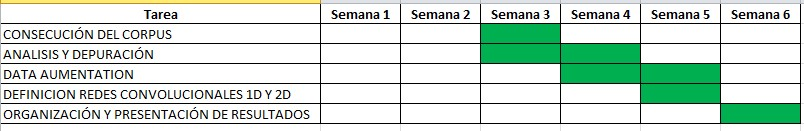



## **1.2. Definición del Corpus**
---


### **1.2.1 Origen**
---

Se utilizarán secuencias de proteínas en formato FASTA provenientes de la base de datos APD: Antimicrobial Peptide Database https://aps.unmc.edu/
- Las secuencias en formato FASTA se convierten a formato CSV y se cargan como dataframe de Python
- Los datos son esencialmente secuencias de texto.
- Para hacer el data augmentation se propone seguir la metodología propuesta en este artículo: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9843584/

### **1.2.1 Adquisición de los datos**
---

In [3]:
import pandas as pd
peptides_df=pd.read_csv("/content/APD_sequence_release_09142020.TAB", sep="\t", header=None)
peptides_df.shape

(3167, 2)

In [4]:
peptides_df.head()

,0,1
0,"00001|Dermaseptin-B2 (XXA, DRS-B2, Dermasepti...",GLWSKIKEVGKEAAKAAAKAAGKAALGAVSEAV
1,"00002|Abaecin (Pro-rich; insects, arthropods, ...",YVPLPNVPQPGRRPFPTFPGQGPFNPKIKWPQGY
2,"00003|Hs-AFP1 (HsAFP1, H. sanguinea antifungal...",DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...
3,"00004|Ct-AMP1 (CtAMP1, C. ternatea-antimicrobi...",NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC
4,"00005|Andropin (insects, arthropods, inverteb...",VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK


### **2.4. Data aumentation**
---


Importamos el dataset con datos aumentados.
El dataset original era aproximadamente de unos 2800 péptidos antimcrobianos divididos en 10 categorias de acuerdo a su actividad.

Los péptidos fueron traducidos de una manera reversa a las posibles cadenas de ADN que los originaron y de ahí se hizo expansón de datos con base en la degeneración del código genético. Esto es posible ya que más de una tripleta puede codificar para un aminoácido. La gráfica muestra el ejemplo de Leucina, que puede ser codificada por seis diferentes tripletas. Esto da un universo de posibles combinaciones que permite expandir el dataset para hacerlo más apto a los métodos de deep learning.

Cada secuencia de péptido fue expandida unas 100 veces. Para un total de unas 280000 secuencias.

 </img>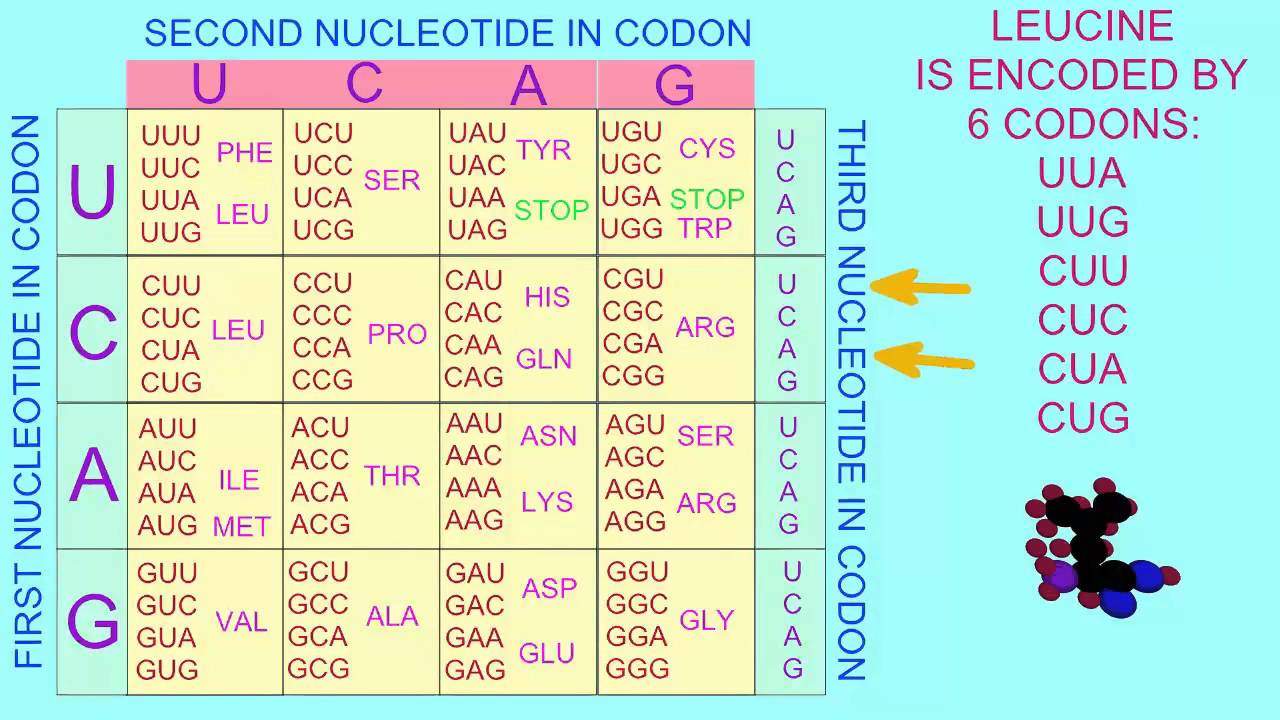

In [5]:
peptides_df=pd.read_csv("/content/all_peptides.top.categories.augmented.100.tab", sep="\t", header=0)
peptides_df.shape

(243412, 2)

In [6]:
# Miramos el encabezado del dataset
peptides_df.head(5)

,Peptide_as_DNA,Activity
0,GGGTTTTGGACTAAAATCAAGGAGGTGGGTAAGGAGGCAGCGAAAG...,Anti_Cancer
1,GGGTTATGGAGGAAAATTAAAGAGGTAGGGAAAGAGGCGGCGAAGG...,Anti_Cancer
2,GGCCTGTGGTCGAAAATAAAAGAGGTTGGCAAGGAGGCTGCTAAAG...,Anti_Cancer
3,GGACTTTGGTCGAAAATCAAAGAGGTCGGCAAGGAAGCCGCAAAGG...,Anti_Cancer
4,GGGCTATGGAGTAAGATAAAAGAAGTCGGCAAGGAAGCGGCCAAAG...,Anti_Cancer


<Axes: xlabel='Activity'>

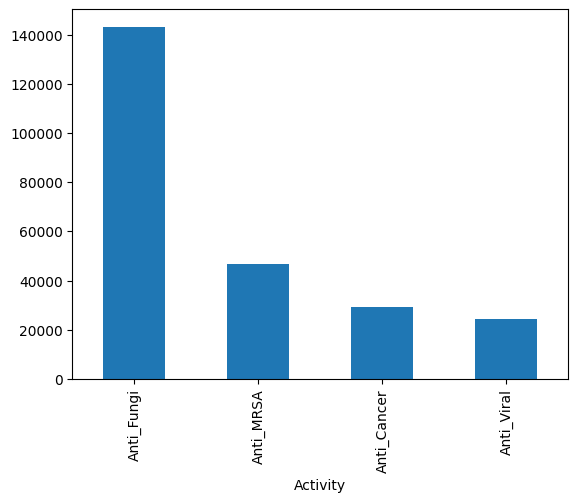

In [7]:
# Graficamos el número de instancias de cada categoria
peptides_df.Activity.value_counts().plot(kind='bar')

Como puede observarse, la gran mayoría de ejemplos están en péptidos antifungicos, segidos por Anti-MRSA (un tipo de bacteria), seguidos por Anti-Cancer.

Los datos están algo desbalanceados. Para balancearlos se hará un balanceo estratificado, pero eso significa que los tamaños de los datasets se reduzcan a niveles de las categorias que menos ejemplos tienen.

# **3. Extracción de Características**
---

## **3.1. Procesamiento de las cadenas de ADN**
---

In [8]:
# Lo primero que hacemos es convertir las secuencias a palabras de 3
# Representando posibles codones
peptides_as_dna = peptides_df['Peptide_as_DNA']
# Definimos un nuevo placeholder para la nueva lista
peptides_as_dna_codons = []
for dna in peptides_as_dna:
  x = []
  for i in range(0, len(dna)-2):
    x.append(dna[i:i+3])
    # Convertimos a x en un string
    X = ' '.join(x)
  peptides_as_dna_codons.append(X)

In [9]:
# Veamos una cadena original
peptides_as_dna[0]

'GGGTTTTGGACTAAAATCAAGGAGGTGGGTAAGGAGGCAGCGAAAGCGGCTGCGAAGGCAGCCGGCAAAGCCGCATTAGGCGCCGTTTGCGAGGCAGTA'

In [10]:
# Definimos una función para el preprocesamiento del texto convertido a trigramas (codones)
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text])
    tokens = word_tokenize(text)
    return ' '.join(tokens)

In [11]:
# Definimos un nuevo dataframe con la nueva representación
zipped = list(zip(peptides_as_dna_codons, peptides_df['Activity'].to_list()))
pepdna_df = pd.DataFrame(zipped, columns=['peptides', 'activity'])

In [12]:
# Verificamos la nueva representación
pepdna_df.head(5)

,peptides,activity
0,GGG GGT GTT TTT TTT TTG TGG GGA GAC ACT CTA TA...,Anti_Cancer
1,GGG GGT GTT TTA TAT ATG TGG GGA GAG AGG GGA GA...,Anti_Cancer
2,GGC GCC CCT CTG TGT GTG TGG GGT GTC TCG CGA GA...,Anti_Cancer
3,GGA GAC ACT CTT TTT TTG TGG GGT GTC TCG CGA GA...,Anti_Cancer
4,GGG GGC GCT CTA TAT ATG TGG GGA GAG AGT GTA TA...,Anti_Cancer


In [13]:
# Convertimos las etiquetas a enteros
# Luego, en otra celda pasaremos las etiquetas a One Hot Encoding
# Necesitamos saber las categorías únicas, tokenizarlas y luego pasarlas a one hot encoding
unique_labels = sorted(set(pepdna_df['activity'].to_list()))
label2idx = {u:i for i, u in enumerate(unique_labels)}
idx2label = np.array(unique_labels)
# Iteramos todos los labels en el dataset y cambiamos el texto por el número correspondiente
# Todo queda guardado en labels_as_int
labels_as_int= []
for label in peptides_df['Activity'].to_list():
  label_as_int = label2idx[label]
  labels_as_int.append(label_as_int)

print("Categorías únicas: ", len(unique_labels))
print("Número total de etiquetas en dataset: ", len(labels_as_int))

Categorías únicas:  4
Número total de etiquetas en dataset:  243412


In [14]:
# En X dejamos las secuencias
X = pepdna_df['peptides']

In [15]:
# Preprocesamos las secuencias
X = X.apply(preprocess)

## **3.2. Implementación del Embedding**
---

In [16]:
# Tokenizamos el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [17]:
# Determinamos el tamaño del vocabulario
# Esto lo necesitaremos posteriormente para definir el embedding
vocab_size = len(tokenizer.word_index) + 1

In [18]:
# Vectorización de X
X_vect = tokenizer.texts_to_sequences(X)

In [19]:
# Longitud vectorizada del primer elemento
len(X_vect[0])

97

In [20]:
# Dejamos los vectores de igual longitud
# Adicionamos padding en caso de ser necesario
max_length = 100
X_vect = pad_sequences(X_vect, maxlen=max_length, padding='post')

In [21]:
# Longitud vectorizada del primer elemento después del padding
len(X_vect[0])

100

In [22]:
# Representación vectorizada del primer elemento
print(X_vect[0])

[ 4 15 20  3  3 12  8  9 54 42 58 21  1  1 22 53 39 11  2 16  9 43 16 15
 10  8  4 15 28 21  2 16  9 43 16 13 14 40 34 27 48  7  1  2 34 27 25 13
 26 19  5 27 48  7  2 16 13 14 40 34 33 51 25 13 14 11  1  2 34 33 51 52
 14 38 17 32 62 16 13 27 52 33 51 50 20  3 12  5 27 48 43 16 13 14 40 35
 28  0  0  0]


In [23]:
# Definimos X y y
# Vamos a utilizar la versión vectorizada de X
X_vect = X_vect
y = np.array(labels_as_int) # Etiquetas en enteros

In [24]:
# Creamos el modelo Word2Vec para el embedding de la primera capa del modelo
sentences = [sentence.split() for sentence in X]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [25]:
# Creamos la capa de embeddings
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [26]:
# Creamos las particiones de datos
X_temp, X_test, y_temp, y_test = train_test_split(X_vect, y, test_size=0.2, random_state = 5, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state = 5, stratify = y_temp)
print(f"Documentos de entrenamiento: {X_train.shape[0]}")
print(f"Documentos de validación: {X_val.shape[0]}")
print(f"Documentos de test: {X_test.shape[0]}")
print(f"Número de categorías: {np.unique(y_train).size}")

Documentos de entrenamiento: 146046
Documentos de validación: 48683
Documentos de test: 48683
Número de categorías: 4


In [27]:
# Codificamos las etiquetas de "y" (que son enteros a one hot encoding) - cod after
yHot_train = tf.keras.utils.to_categorical(y_train)
yHot_val = tf.keras.utils.to_categorical(y_val)
yHot_test = tf.keras.utils.to_categorical(y_test)

# **4. Modelamiento y Evaluación**
---


## **4.1. Entrenamiento y validación de modelo con convoluciones 1D**
---

### **4.1.1. Implementación del modelo**

In [28]:
# Definimos el primer modelo con convoluciones 1D
# La capa de salida es softmax con un tamaño de 4
# Igual el número de categorias de clasificación
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation="softmax"))

In [29]:
# Generamos un resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          6500      
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 19, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 384)               0

In [30]:
# Compilamos el modelo
# Utilizamos categorical_crossentropy porque el problema es multiclase
# Como optimizador utilizamos Adam
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=["accuracy"])

In [31]:
# Definimos callbacks y archivo para guardar el modelo que está siendo monitoreado
# Monitoreamos la pérdida "val_loss"
# En caso de que el modelo no mejore luego de ciertas épocas debería detenerse
# el entrenamiento.
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5", monitor="val_loss",
                                                   verbose=True, save_best_only=True,
                                                   save_weights_only=True, mode="min")

early_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                                  min_delta=0.001, verbose=True)

hist = model.fit(X_train, yHot_train, epochs=10, batch_size =32,
                         validation_data=(X_val, yHot_val), callbacks=[best_callback,
                                                                    early_callback])

Epoch 1/10
4563/4564 [============================>.] - ETA: 0s - loss: 0.8179 - accuracy: 0.6762
Epoch 1: val_loss improved from inf to 0.66296, saving model to model.h5
4564/4564 [==============================] - 162s 35ms/step - loss: 0.8179 - accuracy: 0.6762 - val_loss: 0.6630 - val_accuracy: 0.7222
Epoch 2/10
4562/4564 [============================>.] - ETA: 0s - loss: 0.5677 - accuracy: 0.7532
Epoch 2: val_loss improved from 0.66296 to 0.56737, saving model to model.h5
4564/4564 [==============================] - 155s 34ms/step - loss: 0.5677 - accuracy: 0.7532 - val_loss: 0.5674 - val_accuracy: 0.7489
Epoch 3/10
4564/4564 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.7795
Epoch 3: val_loss improved from 0.56737 to 0.47484, saving model to model.h5
4564/4564 [==============================] - 160s 35ms/step - loss: 0.4837 - accuracy: 0.7795 - val_loss: 0.4748 - val_accuracy: 0.7747
Epoch 4/10
4564/4564 [==============================] - ETA: 0s - loss:

Text(0, 0.5, 'Pérdida')

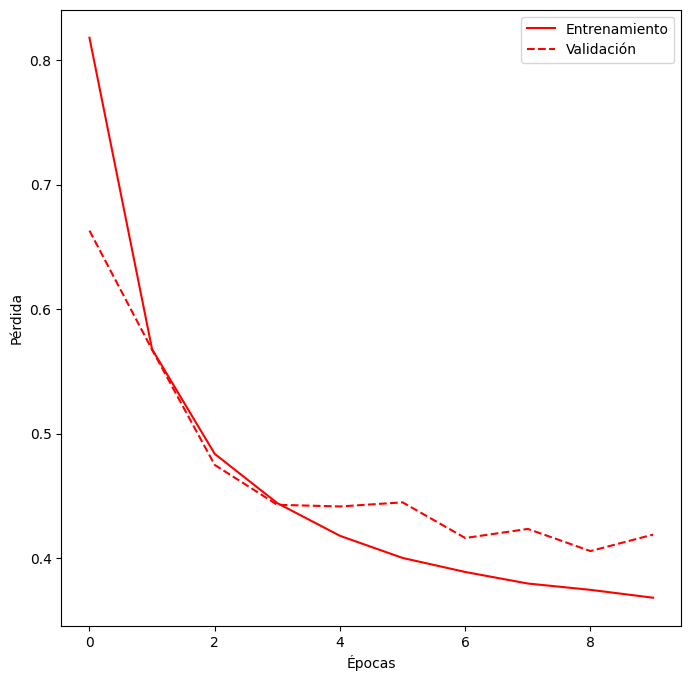

In [32]:
# Graficamos la función de pérdida para las
# particiones de entrenamiento y validación
plt.figure(figsize=(8, 8))
plt.plot(hist.history["loss"], "r", label="Entrenamiento")
plt.plot(hist.history["val_loss"], "r--", label="Validación")
plt.legend(); plt.xlabel("Épocas"); plt.ylabel("Pérdida")

### **4.1.2. Evaluación del modelo**
---

In [33]:
# Generamos el reporte de clasificación
# Este classification report es mañoso, y_test debe ser el original y no el Hot Encoded
print(classification_report(y_test, np.argmax(model.predict(X_test),axis=1)))

1522/1522 [==============================] - 16s 11ms/step
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      5866
           1       0.82      0.89      0.85     28616
           2       0.80      0.69      0.74      9321
           3       0.76      0.61      0.68      4880

    accuracy                           0.79     48683
   macro avg       0.75      0.70      0.72     48683
weighted avg       0.79      0.79      0.79     48683



# **5. Resultados**
---


**5.1 Resultados con convoluciones 1D**
*   El resultado nos muestra un accuracy de aproximadamente 0.8. Esto también se puede evidenciar durante la fase de entrenamiento del modelo, donde el modelo alcanza un "plateau" de 0.8. El hecho de que el accuracy no suba de este punto se debe probablemente a que hay péptidos en más de una cartegoría. Es decir que no son mutuamente exclusivos. Esta es una posible razón de por qué el modelo llega sólo hasta ese punto.

**5.2 Resultados con convoluciones 2D**
*   En este caso el accuracy del modelo no subió de 0.63 y finalizó con early stopping en vista de que no mejoraba. Posibles razones del pobre desempeño del modelo pueden tener que ver con la matriz de 10 x 10 que representa cada péptido. La matriz es muy pequeña y las convoluciones que se aplican a esta matriz no son demasiadas, generando modelos con muy pocos datos. Segun esto, la representación de secuencias cortas con modelos convolucionales 2d es poco eficiente.

**5.3 Resultados con modelo pre entrenado EfficientNet y Transfer Learning**
*   En este caso tuvimos un accuracy un tanto peor que el el modelo de convoluciones 2d. Esto posiblemente esté relacionado con el hecho de que la representación de las secuencias resulta en matrices de pequeño tamaño, las cuales son mejor analizables por convoluciones 1D. En el caso de EfficientNet tenemos representaciones que necesariamente van en tres canales, resultando en matrices con muchos ceros, lo que no es eficiente al momento de representar secuencias biológicas. Se puede concluir que para clasificación es superior el concepto de convoluciones 1D, seguido por convoluciones 2D con un sólo canal, seguido por modelos con convoluciones 2D pero que utilizan más de un canal. También se demuestra que el concepto de transfer learning es utilizable con conceptos tan distantes como una imágen y una secuencia biológica, a pesar de que su eficiencia en este caso no fue la óptima. Con seguridad fuentes de información de secuencia de ADN con mayor información, como lo es el caso de genomas completos, den mejores resultados con estos modelos.

